# Credit Card Fraud Detection
This project is initiated to analyze anonimized dataset provided by **Machine Learning Group - ULB** at Kaggle [here](https://www.kaggle.com/mlg-ulb/creditcardfraud). Since the data is anonymized and doesn't describe time-related relation between each data, we will disregard time series analysis. So, in this project, the data will be analyzed (disregarding time series) to create a model using:
- Artificial Neural Network

I plan to use more machine learning techniques in the near future.

### Import Libraries
Before we begin, let's import some libraries that will help us.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.stats
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score

### Initiate Setup
This setup below is just for us to prepare some data before we begin. Such data can be the location of dataset, random state, and so on.

In [4]:
%matplotlib inline
np.seed = 0

evaluation_portion = 0.2
outlier_percentile = 0.05
dataset_location = './data/creditcard.csv'

In this notebook, we will split the credit card data into two data, *data set* and *data evaluation*. Data set is the data we will use to create our model. Data evaluation, in this notebook, is considered as "anonymous" data that in real world scenario is acquired using real transaction process. This data will let us simulate real world problem (despite the presence of class in this data).

### Load Data
Let's load the data using `pandas` to ease our work.

In [5]:
data = pd.read_csv(dataset_location)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Since we decided to disregard `Time` feature, let's drop it from the data. And since the value in feature `Amount` are way higher than the others, we will need to normalize it.

In [6]:
if 'Time' in data:
    data = data.drop(columns=['Time'])
data['Amount'] = StandardScaler().fit_transform(np.array(data['Amount']).reshape(-1,1))
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


As we can see, now the `Time` feature is deleted and values in `Amount` feature are already normalized.

Since the data contains class, we will create model using classification algorithm. But, before we do that, let's split the data into two parts based on portion. The part with higher portion will be treated as *data set* while the other is treated as *data evaluation*. Let's set the portion to be 80% for data set and 20% for data evaluation.

In [9]:
data_set, data_evaluation = train_test_split(data, test_size = evaluation_portion)
data_set = data_set.sort_index()
data_evaluation = data_evaluation.sort_index()

### Draw Figure

Now that we have split the data, let's put *data evaluation* aside and focus on *data set*.<br>
In order to help us understand the "shape" of data we have, let's create figure representing data from each feature. Since we have two classes, let's separate them and draw the figure side by side. (For the shake of simplicity, the figure shown is only for two features.)

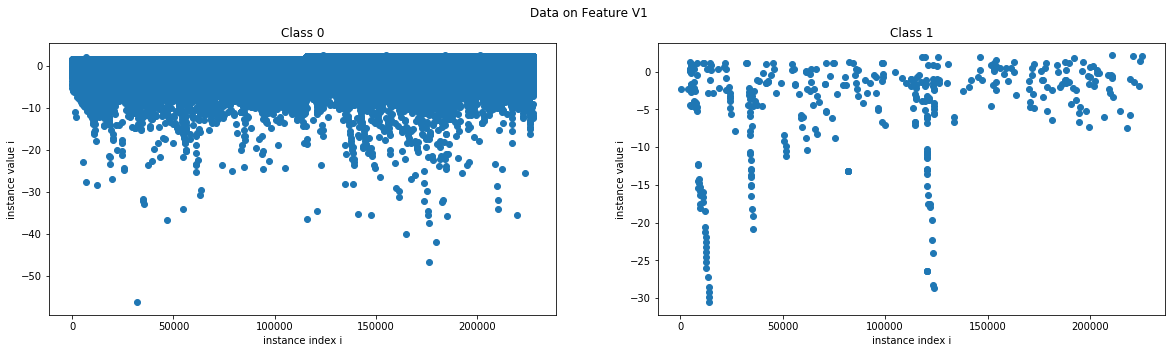

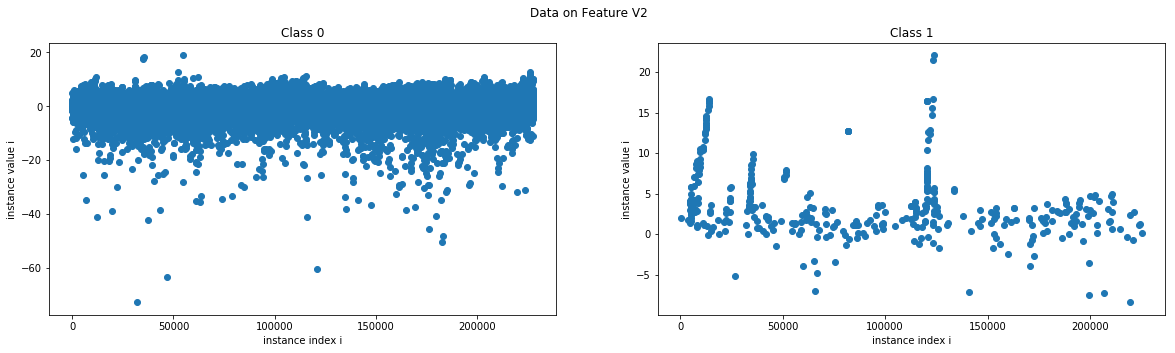

In [10]:
limit_figure = 2

name_of_class, number_of_class = np.unique(data_set.iloc[:,-1], return_counts = True)
feature_names = list(data_set)
class_ix = {}
data_ix = {}
for i in range(len(name_of_class)):
    class_ix[name_of_class[i]] = [j for j in range(len(data_set)) if data_set.iloc[j,-1] == name_of_class[i]]
    data_ix[name_of_class[i]] = [j for j in range(len(data_set)) if data_set.iloc[j,-1] == name_of_class[i]]
for i in range(len(feature_names)):
    if i == len(feature_names)-1:
        continue
    if i >= limit_figure:
        break
    fig = plt.figure(figsize=[20, 5])
    fig.suptitle('Data on Feature {0}'.format(feature_names[i]))
    for j in range(len(name_of_class)):
        y_raw = data_set.iloc[class_ix[name_of_class[j]],i]
        x = data_ix[name_of_class[j]]
        position = int('1{0}{1}'.format(len(name_of_class),j+1))
        ax = fig.add_subplot(position)
        ax.scatter(x, y_raw)
        ax.set_title('Class {0}'.format(name_of_class[j]))
        ax.set_xlabel('instance index i')
        ax.set_ylabel('instance value i')
    plt.show()
    del fig

### Clean Outlier

As we can see from the figures above, there are some values that's way lower or higher than the average data. This may lead to outlier problem. There are some techniques we can use, such as:
* Winsorize
* Tukey's method
* Minkowski error
* Uni- and multi-variate analysis

Since this is the init of the project, we will use Winsorize technique as will the other techniques later. Let's set the percentile value to be 5%.

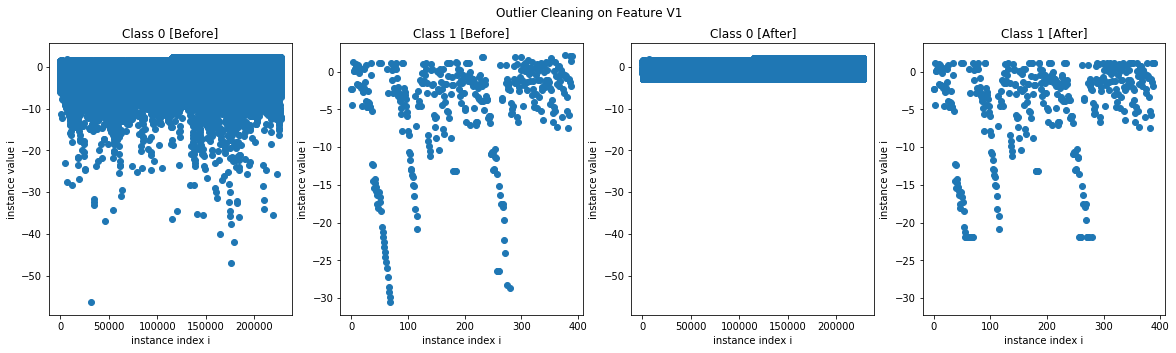

Feature V1 is processed


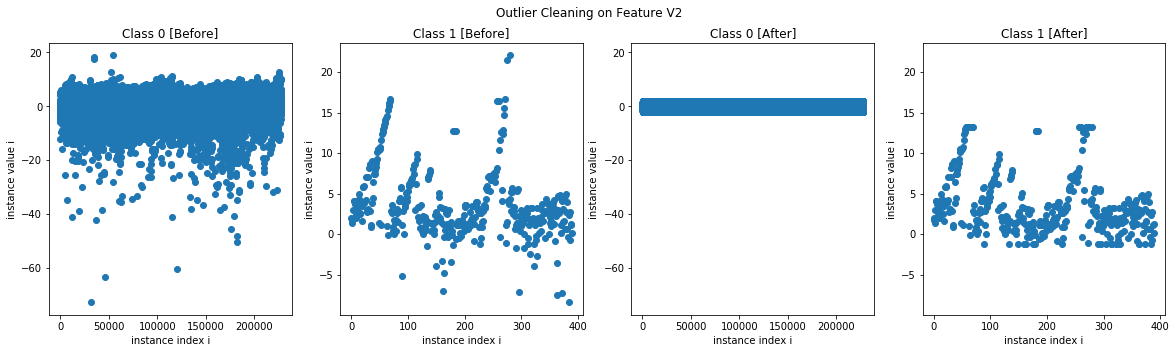

Feature V2 is processed


In [12]:
limit_figure = 2

name_of_class, number_of_class = np.unique(data_set.iloc[:,-1], return_counts = True)
feature_names = list(data_set)
class_ix = {}
data_ix = {}
for i in range(len(name_of_class)):
    class_ix[name_of_class[i]] = [j for j in range(len(data_set)) if data_set.iloc[j,-1] == name_of_class[i]]
    data_ix[name_of_class[i]] = [j for j in range(len(class_ix[name_of_class[i]]))]

data_set_outlier_cleaned = data_set.copy()
for i in range(len(feature_names)):
    if i == len(feature_names)-1:
        break
    temp_data = np.array(data_set_outlier_cleaned.loc[:,feature_names[i]])
    if i < limit_figure:
        fig = plt.figure(figsize=[20,5])
        fig.suptitle('Outlier Cleaning on Feature {0}'.format(feature_names[i]))
    for j in range(len(name_of_class)):
        y_raw = temp_data[class_ix[name_of_class[j]]]
        x = data_ix[name_of_class[j]]
        if i < limit_figure:
            position = int('1{0}{1}'.format(len(name_of_class)*2,j+1))
            ax0 = fig.add_subplot(position)
            ax0.scatter(x, y_raw)
            ax0.set_title('Class {0} [Before]'.format(name_of_class[j]))
            ax0.set_xlabel('instance index i')
            ax0.set_ylabel('instance value i')
        y_cleaned = scipy.stats.mstats.winsorize(y_raw, limits = outlier_percentile)
        if i < limit_figure:
            position = int('1{0}{1}'.format(len(name_of_class)*2,j+1+len(name_of_class)))
            ax1 = fig.add_subplot(position, sharey = ax0)
            ax1.scatter(x, y_cleaned)
            ax1.set_title('Class {0} [After]'.format(name_of_class[j]))
            ax1.set_xlabel('instance index i')
            ax1.set_ylabel('instance value i')
        temp_data[class_ix[name_of_class[j]]] = y_cleaned
    del data_set_outlier_cleaned[feature_names[i]]
    data_set_outlier_cleaned[feature_names[i]] = temp_data
    if i < limit_figure:
        plt.show()
        del fig
        print('Feature {0} is processed'.format(feature_names[i]))
data_set_outlier_cleaned = data_set_outlier_cleaned.reset_index()
del data_set_outlier_cleaned['index']

### Imbalanced class

If we look at the figures above in detail, there we can see that the number of data in class `0` is way higher than class `1`. To confirm this, let's create a function to print figure that will help us.

In [13]:
def print_frequency(data_class):
    name_of_class, number_of_class = np.unique(data_class, return_counts = True)
    size_before = np.array(number_of_class, dtype = float) / np.sum(number_of_class)
    explode = (number_of_class == number_of_class.min()) * 0.2

    fig = plt.figure(figsize=[15,5])
    fig.suptitle('Frequency of Class')
    ax0 = fig.add_subplot('121')
    ax0.pie(size_before, explode = explode, labels = name_of_class, autopct = '%1.1f%%',
          shadow = True, startangle = 45)
    ax0.legend(number_of_class, loc = 'lower right')

    ax1 = fig.add_subplot('122')
    ax1.set_ylabel('Frequency of Class')
    ax1.set_xlabel('Class Label')
    ax1.bar(name_of_class[0], height=number_of_class[0], color='b', label='0')
    ax1.bar(name_of_class[1], height=number_of_class[1], color='y', label='1')
    ax1.set_xticks(name_of_class)
    ax1.set_xticklabels(name_of_class)
    ax1.legend(number_of_class, loc = 'lower right')

    plt.show()

Now, let's call this function.

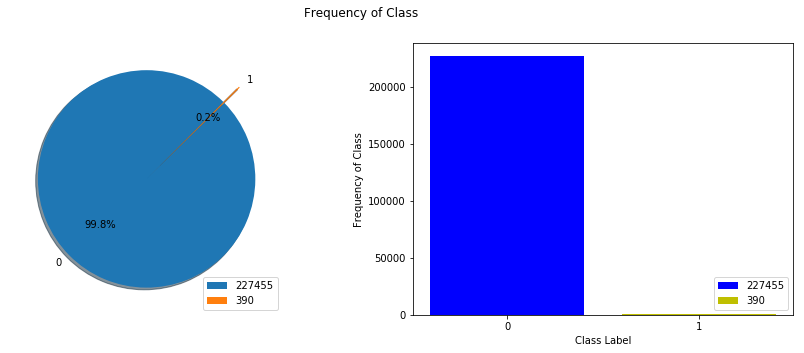

In [14]:
print_frequency(data_set_outlier_cleaned.loc[:,'Class'])

As we've thought, the frequency of class is imbalanced for both classes. The number of class `0` is way higher than class `1`. This clearly shows that the dataset contains imbalanced class problem.

There are some possible solutions we can use:
* 1. Collect more data<br>
Collecting more data is out of question. Since the provided data is confidential and is anonymized, there's no way we can collect new data unless it is provided.
* 2. Under sampling<br>
Under sampling is basically a technique that is used to reduce the number of data.
* 3. Over sampling<br>
Over sampling is a technique that is used to increase the number of data from the current data.
* 4. Combination of under and over sampling<br>
Using only under sampling to reduce the number of data in the majority class often leads to the loss of valuable information. On the other hand, only over sampling the number of data in minority class can also leads to overfitting problem. That's why sometime it's better to combine both technique, under sampling majority class and over sampling minority class.

So, in this notebook, we will use combination of under and over sampling. (Later we will try implementing both under and over sampling.) Now, before we continue, let's split our class feature from the data.

In [16]:
data_set_x = np.array(data_set_outlier_cleaned.iloc[:,1:])
data_set_y = np.array(data_set_outlier_cleaned.iloc[:,0])

In this notebook, the technique we will use is the combinatino of SMOTE (for over sampling) and ENN (for under sampling). Later we will try another available techqnique.

In [17]:
smote_enn = SMOTEENN()
x_resampled, y_resampled = smote_enn.fit_resample(data_set_x, data_set_y)

Now let's see the result of the resampled data for each class.

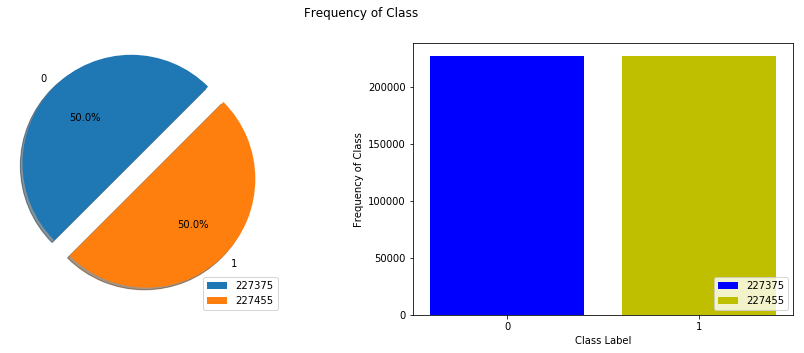

In [18]:
print_frequency(y_resampled)

Now our data is approximately balanced for each class.

### Standardization
Standardization or feature scaling is often used to balance the "influence" of each feature to model creation. Let's say we have feature `F1` with minimum value 0.0 and maximum value 1.0, and feature `F2` with minimum value 100.0 and maximum value 1000.0. In some machine learning algorithms such as artificial neural network, `F1`'s influence will be dominated by `F2`'s. That's why in the beginning we normalized our `Amount` feature since its values are way higher.

Now, before we do the same to the other features, let's create a function to see how our data right now.

In [38]:
def get_feature_data(x):
    data_shape = np.shape(x)

    output = {}
    for i in range(len(feature_names)):
        if feature_names[i] == 'Class':
            output['index'] = ['min', 'max', 'avg', 'std']
            continue
        min_value = np.min(x[:,i])
        max_value = np.max(x[:,i])
        avg_value = np.mean(x[:,i])
        std_value = np.std(x[:,i])
        
        output[feature_names[i]] = [min_value, max_value, avg_value, std_value]
    output = pd.DataFrame(output)
    return output.set_index('index')

Let's call the function to see how our data is.

In [39]:
get_feature_data(x_resampled).head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
index,,,,,,,,,,,,,,,,,,,,,
min,-21.885434,-1.976960,-24.098872,-2.199960,-16.026658,-4.471672,-19.791248,-5.781133,-7.811022,-15.231833,...,-1.424486,-2.457145,-1.522588,-1.371110,-1.144130,-1.413700,-0.697793,-2.634761,-1.115937,-0.353229
max,2.081873,13.208904,2.062256,10.330100,2.937967,3.160919,1.406619,9.435084,1.778829,1.551181,...,2.493224,2.679490,1.687257,1.489302,0.868998,1.454857,0.920556,1.934221,0.875260,2.185955
avg,-2.315582,1.917369,-3.529544,2.253515,-1.634259,-0.796253,-2.748512,0.622392,-1.335423,-2.903860,...,0.191268,0.294889,0.024750,-0.013729,-0.041604,0.056841,0.018031,0.132990,0.045669,-0.044485
std,5.232792,3.297485,6.068182,3.076154,3.969465,1.509640,5.210279,2.359501,2.149916,4.266060,...,0.672807,0.915968,0.700243,0.457786,0.499582,0.536605,0.400185,0.751010,0.343980,0.491621


As we can see from above data, some features have way lower minimum and way higher maximum value than the others. So, let's standardize our data.

In [40]:
scaler_model = StandardScaler()
scaler_model.fit(x_resampled)

x_rescaled = scaler_model.transform(x_resampled)

Let's see how our data is now.

In [42]:
get_feature_data(x_rescaled).head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
index,,,,,,,,,,,,,,,,,,,,,
min,-3.739849e+00,-1.181000e+00,-3.389702e+00,-1.447741e+00,-3.625778e+00,-2.434633e+00,-3.270983e+00,-2.713932e+00,-3.012024e+00,-2.889780e+00,...,-2.401513e+00,-3.004510e+00,-2.209717e+00,-2.965100e+00,-2.206895e+00,-2.740452e+00,-1.788730e+00,-3.685374e+00,-3.376954e+00,-6.280129e-01
max,8.403650e-01,3.424287e+00,9.214950e-01,2.625546e+00,1.151849e+00,2.621269e+00,7.974872e-01,3.734981e+00,1.448545e+00,1.044299e+00,...,3.421423e+00,2.603369e+00,2.374187e+00,3.283264e+00,1.822726e+00,2.605298e+00,2.255269e+00,2.398412e+00,2.411743e+00,4.536912e+00
avg,4.806526e-14,1.370971e-13,3.689729e-14,2.022472e-13,-3.771615e-14,7.843175e-14,7.870770e-14,-1.217279e-15,-3.493365e-14,-1.856663e-14,...,3.413580e-14,-1.165288e-15,-2.155177e-14,-5.646974e-15,1.454986e-15,-2.066537e-14,5.486378e-15,4.435294e-14,3.914714e-14,-8.273896e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Now we have our data in approximately the same range of values with not so different average and standard deviation.

### Classification

Before we classify our `data evaluation`, we need to create a model. And this model is trained based on the `data set` we've processed so far. When building this model, we will use *stratified k fold* with `k = 10`. On every iteration of `k`, we will split our data into 1/k as `data test` and the rest as `data train`. And after prediction, we will print the result in the form of `recall` metric. It's because we want to focus on getting our model to correctly classify class `1` from our data domain, not from prediction domain.

And even though it's uncommon, we will use the value of `k` as the value of epoch to train our model. This way we will gain two things, which is the `recall` value from each `k` and `k` time the models trained.

In [43]:
number_of_k = 10

ann_model = MLPClassifier()
stratified_k_fold = StratifiedKFold(n_splits=number_of_k)
i = 0
for train_index, test_index in stratified_k_fold.split(x_rescaled, y_resampled):
    x_train, y_train = x_rescaled[train_index], y_resampled[train_index]
    x_test, y_test = x_rescaled[test_index], y_resampled[test_index]
    
    ann_model.fit(x_train, y_train)
    y_predict = ann_model.predict(x_test)
    
    i += 1
    print('===================================================')
    print('itration ({0}/{1})'.format(i, number_of_k))
    print('recall: {0}'.format(recall_score(y_test, y_predict)))

itration (1/10)
recall: 1.0
itration (2/10)
recall: 1.0
itration (3/10)
recall: 1.0
itration (4/10)
recall: 1.0
itration (5/10)
recall: 1.0
itration (6/10)
recall: 1.0
itration (7/10)
recall: 1.0
itration (8/10)
recall: 1.0
itration (9/10)
recall: 1.0
itration (10/10)
recall: 1.0


Now after we train our model and test it using stratified k fold with `k = 10`, it's time to test our model with our "unknown" data and let's see the result. 

In [44]:
x_evaluation, y_evaluation = np.array(data_evaluation.iloc[:,:-1]), np.array(data_evaluation.iloc[:,-1])
x_evaluation = scaler_model.transform(x_evaluation)
y_prediction = ann_model.predict(x_evaluation)

print('===================================================')
print('evaluation')
print('recall: {0}'.format(recall_score(y_evaluation, y_prediction)))

evaluation
recall: 0.8529411764705882


And that's the ability of our current model to predict credit card fraud data. Well, As we can see, the recall value dropped from 100% to 85%. This is probably because we haven't cleaned the `data evaluation` from any possible outliers. I will update it later.